# Исследование поведения пользователей мобильного приложения и проведение AAB теста

**Предварительный план работы:**
 - Изучить воронку продаж.
 - Узнать, как пользователи доходят до покупки. 
 - Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.
 - Исследовать результаты A/A/B-эксперимента.
 - Принять решение по результатам A/A/B-теста.
 - 
## Изучение общей информации


In [27]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
import numpy as np
import scipy.stats as st
import math as mth

In [28]:
# чтение файла
logs = pd.read_csv('datasets/logs_exp.csv', sep='\t')

In [29]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [30]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Вывод** 

Данные представляют собой набор событий, с соответствующей этому событию временной меткой, произошедшему с определенным пользователем.

## Подготовка данных

### Замена названий столбцов

In [31]:
# замена названий столбцов
logs = logs.rename(columns={'EventName': 'event', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'date_time', 'ExpId': 'group'})

In [32]:
# замена названий групп
logs['group'] = logs['group'].astype(object)
logs.loc[logs['group'].isin([246, 247, 248]), 'group'] = logs['group'].replace({246: 'A1', 247: 'A2', 248: 'B'})

In [33]:
# проверка изменений
display(logs.columns)
logs['group'].unique()

Index(['event', 'user_id', 'date_time', 'group'], dtype='object')

array(['A1', 'B', 'A2'], dtype=object)

### Проверка пропусков и типов данных.

In [34]:
# проверка пропусков
logs.isnull().sum()

event        0
user_id      0
date_time    0
group        0
dtype: int64

Приведем к нужному типу даты столбец `date_time`. В файле, данные предоставлены в секундах. Так же поищем дубликаты.

In [35]:
logs['date_time'] = pd.to_datetime(logs['date_time'], unit='s')

In [36]:
# поиск и дальнейшие действия с дубликатами
display(f"Дубликатов в данных: {logs.duplicated().sum()}")
display('Доля дубликатов в таблице: {:.2%}'.format(logs.duplicated().sum() / len(logs)))

logs = logs.drop_duplicates()

display(f"Дубликатов в данных после удаления: {logs.duplicated().sum()}")

'Дубликатов в данных: 413'

'Доля дубликатов в таблице: 0.17%'

'Дубликатов в данных после удаления: 0'

### Добавление столбца даты и времени и отдельного столбца с датами

In [37]:
logs['date'] = pd.to_datetime(logs['date_time'].dt.date)

In [38]:
# проверка
logs.head()

,event,user_id,date_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


**Вывод**
1. Заменены названия столбцов.
2. Заменены названия групп в столбце `group` на удобные:
  - `A1` первая контрольная группа,
  - `A2` вторая контрольная группа,
  - `B` контрольная группа.
3. Пропуски проверены и необнаружены.
4. Дубликатов обнаружено незначительных 0.17%, было принято решение их удалить.
5. Столбец `date_time` приведен к временному типу данных.
6. К фрейму добавлен столбец `date` с датой события.

## Изучение данных

### Число событий в логе

In [39]:
# подсчет собыытий
display(f"В логе содержится {logs['event'].nunique()} уникальных событий, с названиями {', '.join(logs['event'].unique())}")
display(f"Всего событий: {len(logs['event'])}")

'В логе содержится 5 уникальных событий, с названиями MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, Tutorial'

'Всего событий: 243713'

### Число пользователей в логе

In [40]:
display(f"В логе {logs['user_id'].nunique()} пользователей")

'В логе 7551 пользователей'

### Число событий  на пользователя

In [41]:
events_per_user = logs.groupby('user_id')['event'].count().reset_index()
display(f"Среднее количество событий на пользователя: {round(events_per_user['event'].mean())}")

'Среднее количество событий на пользователя: 32'

### Данные за период

In [42]:
display(f"Данные за период с {logs['date'].dt.date.min()} по {logs['date'].dt.date.max()}")

'Данные за период с 2019-07-25 по 2019-08-07'

### Количество событий в зависимости от времени в разрезе групп

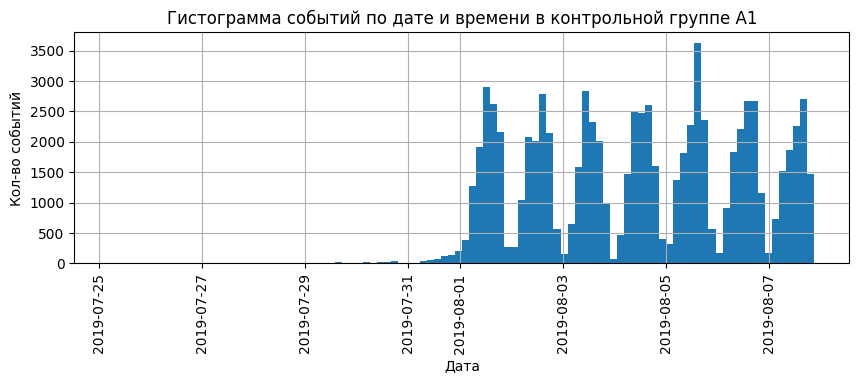

In [43]:
group_A1 = logs[logs['group'] == 'A1']
group_A1['date_time'].hist(bins=100, figsize=(10,3))
plt.title('Гистограмма событий по дате и времени в контрольной группе А1')
plt.ylabel('Кол-во событий')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

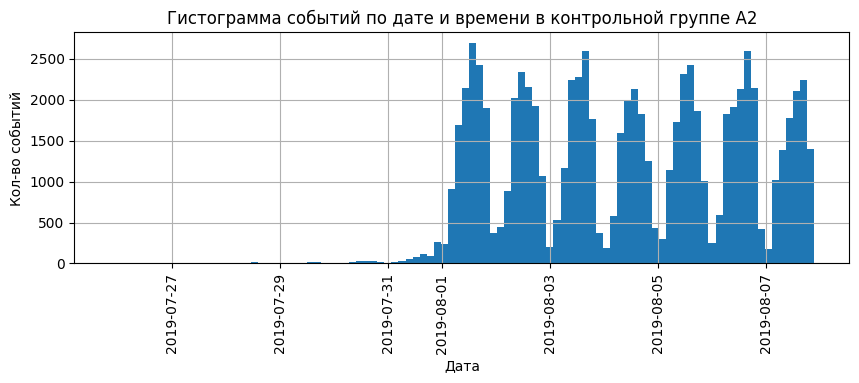

In [44]:
group_A2 = logs[logs['group'] == 'A2']
group_A2['date_time'].hist(bins=100, figsize=(10,3))
plt.title('Гистограмма событий по дате и времени в контрольной группе A2')
plt.ylabel('Кол-во событий')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

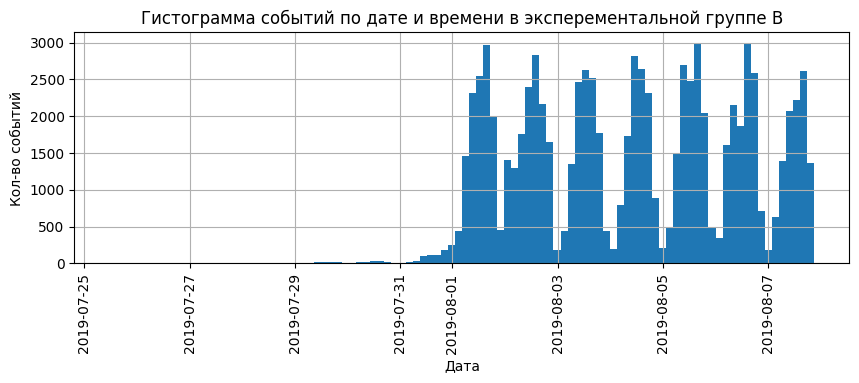

In [45]:
group_B = logs[logs['group'] == 'B']
group_B['date_time'].hist(bins=100, figsize=(10,3))
plt.title('Гистограмма событий по дате и времени в эксперементальной группе B')
plt.ylabel('Кол-во событий')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

Судя по гисограммам, мы располагаем не полными данными за весь период. Для предотвращения "перекашивания" данных, определим 1 августа, как момент полных данных. Отфильтруем события произошедшие до 1 августа и построим гистограмму с актуальными данными. Строить три гистограммы в разрезе групп на данном этапе смысла нет.

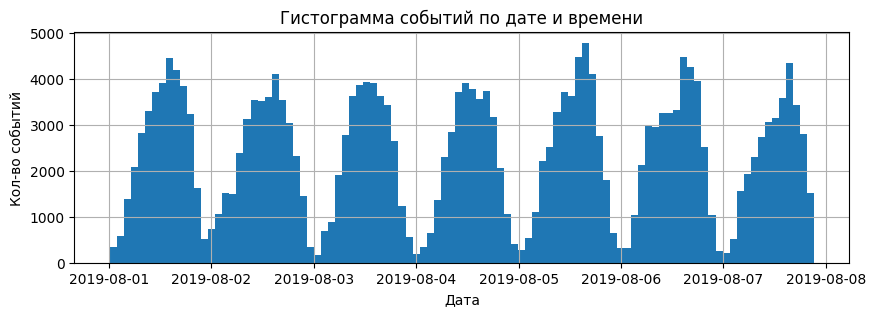

In [46]:
# Фильтруем данные
logs_act = logs.query('date_time > "2019-08-01"')

# Строим гистограмму
logs_act['date_time'].hist(bins=100, figsize=(10,3))
plt.title('Гистограмма событий по дате и времени')
plt.ylabel('Кол-во событий')
plt.xlabel('Дата')
plt.show()

### Количество потерянных данных

In [47]:
# считаем потерянные данные
display(f'Потеряли событий: {len(logs)-len(logs_act)}')
display(f'Потеряли пользователей: {len(logs["user_id"].unique())-len(logs_act["user_id"].unique())}')

'Потеряли событий: 2826'

'Потеряли пользователей: 17'

In [48]:
# Рассчитываем относительные потери
total_events = len(logs)
lost_events = len(logs) - len(logs_act)
events_loss_ratio = lost_events / total_events

total_users = len(logs['user_id'].unique())
lost_users = len(logs['user_id'].unique()) - len(logs_act['user_id'].unique())
users_loss_ratio = lost_users / total_users

# Выводим результаты
display(f'Относительные потери событий: {events_loss_ratio:.2%}')
display(f'Относительные потери пользователей: {users_loss_ratio:.2%}')


'Относительные потери событий: 1.16%'

'Относительные потери пользователей: 0.23%'

Потери событий и пользователей незначительны

### Проверка наличия пользователей из всех трех групп

In [49]:
count_users_per_group = logs_act.groupby('group').agg({'user_id': 'nunique'})
count_users_per_group

,user_id
group,
A1,2484
A2,2513
B,2537


Посчитали пользователей в разрезе групп. Количество разнится незначительно.

## Шаг 4. Изучение воронки событий

### Частота событий

In [50]:
display(logs_act['event'].value_counts())

event
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

1. Главный экран. (Пользователь взаимодействует с главным экраном приложения.)
2. Каталог предложений. (Пользователь переходит к каталогу предложений с главного экрана.)
3. Карточка товара. (Пользователь выбирает конкретный товар из каталога и переходит на карточку товара для получения подробной информации.)
4. Экран с подтверждением успешной оплаты. (После выбора товара, пользователь совершает оплату, и если операция успешна, появляется экран с подтверждением оплаты.)
5. Руководство пользователя. (Пользователь знакомится с общей информацией о приложении.)

Присутствие `Tutorial` в событиях:
 - `Tutorial` – событие с самым низким уровнем участия.
 - Ознакомление с продуктом происходит на начальном этапе и пользователи пропускают этот этап по факту его не проходя.
 - Если включим `Tutorial` в воронку, это исказит данные.

**Решение**:
`Tutorial` в дальнейшем анализе не рассматривать.

### Подсчет пользователей совершивших каждое из этих событий.

In [51]:
logs_funnel_users = (logs_act[logs_act['event'] != 'Tutorial']
                    .groupby('event')['user_id'].nunique()
                    .sort_values(ascending=False)
                    .head(4)
                    .reset_index(name='total_users')
                    .assign(percent=lambda x: x['total_users'] / logs_act['user_id'].nunique() * 100)
                   )


In [52]:
logs_funnel_users

,event,total_users,percent
0,MainScreenAppear,7419,98.473586
1,OffersScreenAppear,4593,60.963632
2,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719


### Порядок событий

1. Главный экран. (Пользователь взаимодействует с главным экраном приложения.)
2. Каталог предложений. (Пользователь переходит к каталогу предложений с главного экрана.)
3. Карточка товара. (Пользователь выбирает конкретный товар из каталога и переходит на карточку товара для получения подробной информации.)
4. Экран с подтверждением успешной оплаты. (После выбора товара, пользователь совершает оплату, и если операция успешна, появляется экран с подтверждением оплаты.)

В последовательную цепочку выстраиваются все события, кроме Tutorial.

### Относительные показатели пользователей в разрезе событий

In [53]:
fig = go.Figure(go.Funnel(y = logs_funnel_users['event'],
                          x = logs_funnel_users['total_users'],
                          opacity = 1.0,
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title_text='Воронка событий')
fig.show()


 - Больше всего пользователей **38%** теряется после первого события.
 - От начала и до конца доходят лишь **48%**

## Анализ результатов эксперимента

In [54]:
user_group = logs_act.groupby('group')['user_id'].nunique()
user_group['A1A2'] = user_group['A1'] + user_group['A2']
user_group

group
A1      2484
A2      2513
B       2537
A1A2    4997
Name: user_id, dtype: int64

В контрольных группах А1 и А1, 2484 и 2513 пользователей соответственно. В экпериментальной группе 2537 пользователей.

Проверим, есть ли пользователи которые попали в несколько тестовых групп.

In [55]:
display('Пользоветели в группе A1 и A2:',len(logs_act.loc[logs_act['user_id'].isin(logs_act[logs_act['event']=='A1']['user_id']) & 
               logs_act['user_id'].isin(logs_act[logs_act['event']=='A2']['user_id']),'user_id'].unique()))
display('Пользоветели в группе A1 и B:',len(logs_act.loc[logs_act['user_id'].isin(logs_act[logs_act['event']=='A1']['user_id']) & 
               logs_act['user_id'].isin(logs_act[logs_act['event']=='B']['user_id']),'user_id'].unique()))
display('Пользоветели в группе A2 и B:',len(logs_act.loc[logs_act['user_id'].isin(logs_act[logs_act['event']=='A2']['user_id']) & 
               logs_act['user_id'].isin(logs_act[logs_act['event']=='B']['user_id']),'user_id'].unique()))

'Пользоветели в группе A1 и A2:'

0

'Пользоветели в группе A1 и B:'

0

'Пользоветели в группе A2 и B:'

0

Пользователей попавших в несколько групп нет. Количество пользователей в разрезе групп разниться не сильно. Проведение теста допустимо.

### Проверка статичтически значимой разницы между двумя контрольными группами (A1 и A2).
 
Для проверки создадим сводную создадим таблицу с группировкой по событиям и количеством пользователей каждой группы по событиям, уберем событие `Tutorial`, отсортируем последовательность событий по воронке и добавим столбец с суммой пользователей контрольных групп.

In [56]:
event_group = logs_act.pivot_table(index='event', values='user_id', columns='group', aggfunc='nunique').reset_index()
event_group = event_group.sort_values(by='A1', ascending=False)
event_group = event_group.head(4).reset_index(drop=True)
event_group['A1A2'] = event_group['A1'] + event_group['A2']
event_group

group,event,A1,A2,B,A1A2
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


Создадим таблицу с долями

In [57]:

event_group_ratio = pd.DataFrame(event_group['event'])
event_group_ratio['A1_ratio'] = (event_group['A1'] / user_group['A1'] * 100).round(2)
event_group_ratio['A2_ratio'] = (event_group['A2'] / user_group['A2'] * 100).round(2)
event_group_ratio['B_ratio'] = (event_group['B'] / user_group['B'] * 100).round(2)
event_group_ratio['A1A2_ratio'] = (event_group['A1A2'] / (user_group['A1'] + user_group['A2']) * 100).round(2)
event_group_ratio

,event,A1_ratio,A2_ratio,B_ratio,A1A2_ratio
0,MainScreenAppear,98.63,98.53,98.27,98.58
1,OffersScreenAppear,62.08,60.49,60.35,61.28
2,CartScreenAppear,50.97,49.26,48.48,50.11
3,PaymentScreenSuccessful,48.31,46.08,46.55,47.19


Гипотеза Н0: Разницы между группами А1 и А2 нет

Гипотеза Н1: Разница между группами А1 и А2 есть

Уровень значимости: 0.01
Для проверки, находят ли статистические критерии разницу между группами А1 и А2 будет иплользована функция с применением Z-критерия.

In [58]:
"""
Функция принимает на вход название групп и уровень значимости и проходя по событиям воронки проверяет 
с помощью Z-теста статистическую значимость разницы между долями от общего числа пользователей группы
"""
def z_test(group1, group2, alpha):
    print('Проверка групп:',group1,'и', group2)
    print('при уровне значимости: {:.0%}'.format(alpha))
    
    for i in event_group.index:
        # пропорция успехов в первой группе:
        p1 = event_group[group1][i] / user_group[group1]
        
        # пропорция успехов во второй группе:
        p2 = event_group[group2][i] / user_group[group2]
        
        # пропорция успехов в комбинированном датасете:
        p_combined = (event_group[group1][i] + event_group[group2][i]) / (user_group[group1] + user_group[group2])
        
        # разница пропорций в датасетах
        difference = p1 - p2
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = (difference / mth.sqrt(p_combined * (1 - p_combined) *
                    (1 / user_group[group1] + 1 / user_group[group2])))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('--------------------------------')
        print()
        print('Событие >', event_group['event'][i])
        print()
        print('Уровень P-value:', p_value)
        
        if (p_value < alpha):
            print("Разница между тест группами есть")
        else:
            print("Разницы между тест группами нет")
            
        print()

Проведем тесты между всеми группами, с уровнями статистической значимости 0.05 и 0.01

In [59]:
z_test("A1", "A2", 0.05)

Проверка групп: A1 и A2
при уровне значимости: 5%
--------------------------------

Событие > MainScreenAppear

Уровень P-value: 0.7570597232046099
Разницы между тест группами нет

--------------------------------

Событие > OffersScreenAppear

Уровень P-value: 0.2480954578522181
Разницы между тест группами нет

--------------------------------

Событие > CartScreenAppear

Уровень P-value: 0.22883372237997213
Разницы между тест группами нет

--------------------------------

Событие > PaymentScreenSuccessful

Уровень P-value: 0.11456679313141849
Разницы между тест группами нет



In [61]:
z_test("A1", "A2", 0.01)

Проверка групп: A1 и A2
при уровне значимости: 1%
--------------------------------

Событие > MainScreenAppear

Уровень P-value: 0.7570597232046099
Разницы между тест группами нет

--------------------------------

Событие > OffersScreenAppear

Уровень P-value: 0.2480954578522181
Разницы между тест группами нет

--------------------------------

Событие > CartScreenAppear

Уровень P-value: 0.22883372237997213
Разницы между тест группами нет

--------------------------------

Событие > PaymentScreenSuccessful

Уровень P-value: 0.11456679313141849
Разницы между тест группами нет



In [62]:
z_test("A1", "B", 0.05)

Проверка групп: A1 и B
при уровне значимости: 5%
--------------------------------

Событие > MainScreenAppear

Уровень P-value: 0.2949721933554552
Разницы между тест группами нет

--------------------------------

Событие > OffersScreenAppear

Уровень P-value: 0.20836205402738917
Разницы между тест группами нет

--------------------------------

Событие > CartScreenAppear

Уровень P-value: 0.07842923237520116
Разницы между тест группами нет

--------------------------------

Событие > PaymentScreenSuccessful

Уровень P-value: 0.2122553275697796
Разницы между тест группами нет



In [63]:
z_test("A1", "B", 0.01)

Проверка групп: A1 и B
при уровне значимости: 1%
--------------------------------

Событие > MainScreenAppear

Уровень P-value: 0.2949721933554552
Разницы между тест группами нет

--------------------------------

Событие > OffersScreenAppear

Уровень P-value: 0.20836205402738917
Разницы между тест группами нет

--------------------------------

Событие > CartScreenAppear

Уровень P-value: 0.07842923237520116
Разницы между тест группами нет

--------------------------------

Событие > PaymentScreenSuccessful

Уровень P-value: 0.2122553275697796
Разницы между тест группами нет



In [64]:
z_test("A2", "B", 0.05)

Проверка групп: A2 и B
при уровне значимости: 5%
--------------------------------

Событие > MainScreenAppear

Уровень P-value: 0.4587053616621515
Разницы между тест группами нет

--------------------------------

Событие > OffersScreenAppear

Уровень P-value: 0.9197817830592261
Разницы между тест группами нет

--------------------------------

Событие > CartScreenAppear

Уровень P-value: 0.5786197879539783
Разницы между тест группами нет

--------------------------------

Событие > PaymentScreenSuccessful

Уровень P-value: 0.7373415053803964
Разницы между тест группами нет



In [65]:
z_test("A2", "B", 0.01)

Проверка групп: A2 и B
при уровне значимости: 1%
--------------------------------

Событие > MainScreenAppear

Уровень P-value: 0.4587053616621515
Разницы между тест группами нет

--------------------------------

Событие > OffersScreenAppear

Уровень P-value: 0.9197817830592261
Разницы между тест группами нет

--------------------------------

Событие > CartScreenAppear

Уровень P-value: 0.5786197879539783
Разницы между тест группами нет

--------------------------------

Событие > PaymentScreenSuccessful

Уровень P-value: 0.7373415053803964
Разницы между тест группами нет



In [66]:
z_test("A1A2", "B", 0.05)

Проверка групп: A1A2 и B
при уровне значимости: 5%
--------------------------------

Событие > MainScreenAppear

Уровень P-value: 0.29424526837179577
Разницы между тест группами нет

--------------------------------

Событие > OffersScreenAppear

Уровень P-value: 0.43425549655188256
Разницы между тест группами нет

--------------------------------

Событие > CartScreenAppear

Уровень P-value: 0.18175875284404386
Разницы между тест группами нет

--------------------------------

Событие > PaymentScreenSuccessful

Уровень P-value: 0.6004294282308704
Разницы между тест группами нет



In [67]:
z_test("A1A2", "B", 0.01)

Проверка групп: A1A2 и B
при уровне значимости: 1%
--------------------------------

Событие > MainScreenAppear

Уровень P-value: 0.29424526837179577
Разницы между тест группами нет

--------------------------------

Событие > OffersScreenAppear

Уровень P-value: 0.43425549655188256
Разницы между тест группами нет

--------------------------------

Событие > CartScreenAppear

Уровень P-value: 0.18175875284404386
Разницы между тест группами нет

--------------------------------

Событие > PaymentScreenSuccessful

Уровень P-value: 0.6004294282308704
Разницы между тест группами нет



**Общий вывод:**

1. **Общая информация:**
   - Датасет содержит информацию о событиях, ID пользователя, времени события и номере экспериментальной группы.
   - Время событий записано в неправильном формате. Существуют события, такие как 'Появление главного экрана', 'Появление экрана оплаты', и др., которые являются частью воронки продаж на сайте.
   - В логе есть 5 событий, в порядке убывания их популярности: показ главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения.
   - Всего 7,551 пользователь в логе. В среднем на пользователя приходится 32 события, но это число завышено из-за выбросов. Большинство пользователей имеют от 0 до 30 событий.

2. **Преобразование данных:**
   - В таблице удалены дубликаты, откорректированы типы данных, добавлен столбец с датой. Пропусков в таблице нет.

3. **Воронка событий:**
   - События формируют воронку продаж, где самое популярное - показ главного экрана, а наименее популярное событие, входящее в воронку продаж - показ экрана оплаты.
   - Предполагаемая воронка продаж включает следующие этапы: 
     1. Пользователь видит главный экран сайта.
     2. Пользователь переходит на товар.
     3. Пользователь добавляет товар в корзину и переходит в нее.
     4. Пользователь оплачивает заказ.
   - Дополнительное событие - "обучение" - не является обязательным, так как на него переходит всего 4% пользователей.

4. **Анализ воронки:**
   - Подсчитан процент пользователей, проходящих каждый этап воронки от предыдущего шага.
   - На экран с предложением переходит 62% пользователей, посмотревших главный экран.
   - На экран с корзиной переходит 81% пользователей.
   - На экран с успешной оплатой переходит 95% пользователей от предыдущего шага.
   - К оплате переходит 95% пользователей от предыдущего шага, а вот к экрану с предложением проходит только 62% пользователей.
   - От показа главного экрана до товарной оплаты доходит 48% пользователей.

5. **Результаты A/B-тестирования:**
   - Новые шрифты из группы Б не оказали влияния на поведение пользователей в приложении.
   - Доля пользователей, совершивших покупки, осталась практически без изменений.